# **Detecting Errors in Waveform Images**
This code allows you to cluster waveform images generated from generate_data/generate_waveform_dataset.ipynb.

## **The Dataset**
This code must be used with a dataset that follows a very specific format. An example called images_april06_small.zip can be found in the clustering folder. Github does not allow for large files to be uploaded so it is a very small dataset with 15 families with 20 images each.

*   Images have names with labels in the the format: (5-digit familycode)(good/bad waveform)(date).png ex. **YYJ96H**good**0220025820.805883**.png  
*   Images are stored in a folder called "images"
*   This was created using Google Colab so by default the folder is found in the directory "content"
*   The full path of an example image is content/images/OCREJ5good0220025717.761071.png
*   All images are of size (1000, 1400) and have a white background 
*   [15:21] of the full image path contains the 5-digit family code and [21:24] contains the first 3 letters of the error label (goo/bad)

## **Creating a Dataset**
For this code to work, the proportion of images with and without errors must be approximately equal. If this doesn't happen, the model may simply classify all images as the minority class. In addition, the model should have enough images per family (ideally 20+). Generally, the more data, the better the model can preform so if you have more labeled data, I would recommend using it.

## **Editing the Preprocessing Code**

#### **Different Folder Names, Image Names, or Full Path**
If folder names, images names, or the full path of the images stray from this example, the cell commented "Create dataset" will likely need to be edited. In this cell, the folder is opened so if the folders or full path is changed, that line will need to be edited. In addition, file[21:24] will likely not be the error label. In the first line of the loop, both the family code and the error label are printed. If these are not correct, make sure to change them there and when they get appended to y and y_errors a few lines below that. 

#### **Different Sized Images or Images Made with a Different Tool**
The images I used were made using matplotlib.pyplot but if a different tool was used or they are a different size, you will likely have to edit the cell commented "Create dataset". In the preprocessing, images are edited to be black and white. This code is there to reduce variation between images with different colored lines. This code can be removed if all images have a green background and a white line, for example. 

#### **K-Means**
The code requires you to specify a range of possible k values (# of clusters) to test below. The ideal number of clusters will likely be near the number of families in the dataset. 

## **The Model**
![](https://drive.google.com/uc?export=view&id=1pKgYpH5eSukE0WUGhGy5LBc_jzMFrqI6)

#### **Description**
Above is a diagram of the model included in this code. First the images are preprocessed. In this code, they are sized-down because we had limited RAM and our kernel often died when we did not. However, if that is not an issue, that line could be removed which might improve the error detection. We also converted images to black and white in order to reduce variation but if images are already the same color that may not be needed. Additionally, while not done in this code, if images are coming from multiple different graphing tools, you might consider cropping out the axes to prevent waveforms from being grouped by the graphing software rather than the shape of the waveform.

After the images are filtered, 500 dimension Resnet-18 image embeddings (lower-dimension vectors that summarize the features of the images) are created using the package img2vec for each of the images. These are then clustered into groups using k-means. Next, the resulting group labels along with their corresponding images are inputted into the Convolutional Neural Network (CNN) model. The output of the model is either a 1 indicating that the image may contain an error or a 0 indicating it likely does not. 

#### **Training the Model**

##### **Train Test Validation**
To train the model, a training, testing, and validation set are used. In this code the training set is 70% of the data, the testing set is 20%, and the validation set is 10% of the data. True to its name, the training set is used to train the model on, the validation set is used to test the model after each epoch of training, and the testing set is used to test the model after the it has been trained. The validation accuracy can be used to know when training should be stopped so that the model does not overfit the training data.

##### **Underfitting and Overfitting**
If the training accuracy and the testing accuracy are low, the model is likely underfitting the data and you might want to train the model for more epochs. If the training accuracy is high and the testing accuracy is signifigantly lower, the model is likely overfitting the data and you might want to train the model for less epochs or get more data.


In [1]:
# installs
!pip3 install img2vec_pytorch
!pip3 install Pillow
!pip3 install scikit-learn

In [2]:
# imports 
import numpy as np
import glob
import cv2
from sklearn.datasets import make_blobs
from PIL import Image
from img2vec_pytorch import Img2Vec
from sklearn import metrics

import matplotlib.pyplot as plt

import pandas as pd
from scipy import stats
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage import img_as_bool

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [20]:
# download dataset
!unzip images_mar10_2000.zip

Archive:  images_mar10_2000.zip
  inflating: content/images/UBP9XAgood0310171135.403393.png  
  inflating: content/images/QFRI7Qbad0310170726.309922.png  
  inflating: content/images/7LW3RDbad0310171326.082701.png  
  inflating: content/images/XATEN2bad0310170906.788400.png  
  inflating: content/images/GZ7PYAbad0310170531.969574.png  
  inflating: content/images/I0KDYFgood0310171046.681965.png  
  inflating: content/images/JND8Q6bad0310170606.812108.png  
  inflating: content/images/WFRKZBbad0310171112.020099.png  
  inflating: content/images/PLO869good0310170739.453565.png  
  inflating: content/images/FFLRG8bad0310171342.941969.png  
  inflating: content/images/B9TZ94good0310170413.275602.png  
  inflating: content/images/6OOC7Ggood0310170626.108772.png  
  inflating: content/images/JJQXFCgood0310170325.148081.png  
  inflating: content/images/FFLRG8bad0310171343.910992.png  
  inflating: content/images/32CTBXgood0310171105.012809.png  
  inflating: content/images/NCM4LZbad031017094

In [21]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True)

In [22]:
# Create dataset
X = []
X_vec = []
y = []
path = "content/images/*.*"
for file in glob.glob(path):
  print(file[15:21], file[21:24])

  # open image
  img = cv2.imread(file, 0)
  # make image binary
  ret, img_binary = cv2.threshold(img, 246, 255, cv2.THRESH_BINARY)

  if img_binary is not None:
    # file[21:24] is the error label (good/bad)
    if file[21:24] == 'goo':
      y.append(0)
    else:
      y.append(1)

    # cropping out axes  
    print(img_binary.shape)
    img_binary = img_as_bool(resize(img_binary, (200, 275)))

    # 3d
    stacked_img = np.stack([img_binary,]*3, axis=-1).astype(int)  

    # convert to PIL
    PIL_image = Image.fromarray(np.uint8(stacked_img)).convert('RGB')
    
    # Get an image embedding from img2vec, returned as a torch FloatTensor
    X_vec.append(img2vec.get_vec(PIL_image, tensor=True))
    X.append(img_binary)
 

Streaming output truncated to the last 5000 lines.
IGT7IQ bad
(1000, 1400)
FU4W9K goo
(1000, 1400)
VCXXT2 bad
(1000, 1400)
ADCXM5 bad
(1000, 1400)
CU1NJ2 bad
(1000, 1400)
U92TE4 goo
(1000, 1400)
OMSVWU goo
(1000, 1400)
4ENZL2 goo
(1000, 1400)
G5QAG5 goo
(1000, 1400)
YHO58U goo
(1000, 1400)
VCXXT2 goo
(1000, 1400)
OMSVWU goo
(1000, 1400)
TOHHWF bad
(1000, 1400)
QFRI7Q goo
(1000, 1400)
PLO869 bad
(1000, 1400)
OXDH5A goo
(1000, 1400)
65GSMQ bad
(1000, 1400)
0TBS5D goo
(1000, 1400)
T1D2MV bad
(1000, 1400)
XOSPHF bad
(1000, 1400)
Z2KQ3R bad
(1000, 1400)
6OOC7G bad
(1000, 1400)
I0KDYF goo
(1000, 1400)
U5293J bad
(1000, 1400)
G9A6CM goo
(1000, 1400)
VCXXT2 bad
(1000, 1400)
IJCTH4 goo
(1000, 1400)
G5QAG5 goo
(1000, 1400)
OMSVWU bad
(1000, 1400)
4ENZL2 bad
(1000, 1400)
E6G2U5 goo
(1000, 1400)
VDPENQ goo
(1000, 1400)
VDPENQ goo
(1000, 1400)
U92TE4 bad
(1000, 1400)
IGT7IQ goo
(1000, 1400)
FU4W9K bad
(1000, 1400)
L4GGBH goo
(1000, 1400)
7LW3RD bad
(1000, 1400)
NCM4LZ goo
(1000, 1400)
YL6WCH bad
(1

In [23]:
# check lengths 
len(y), len(X)

(3800, 3800)

In [24]:
# convert the pytorch tensors to numpy vectors
X_vec = np.array([t.squeeze().numpy() for t in X_vec])

In [25]:
# test a range of k values (possible number of clusters) and print resulting silhouette scores
max_k, max_ss = -10, 0
for k in range(20,51):
  kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=1)
  kmeans_model.fit(X_vec)
  silhouette_score = metrics.silhouette_score(X_vec, kmeans_model.labels_, metric='euclidean')
  print('k =', k, 'silhouette score:', silhouette_score)
  # update max_ss and max_k if larger
  if silhouette_score > max_ss:
    max_k = k
    max_ss = silhouette_score

k = 20 silhouette score: 0.17615119
k = 21 silhouette score: 0.1692175
k = 22 silhouette score: 0.17579465
k = 23 silhouette score: 0.17694527
k = 24 silhouette score: 0.17129336
k = 25 silhouette score: 0.17578195
k = 26 silhouette score: 0.17177925
k = 27 silhouette score: 0.18149425
k = 28 silhouette score: 0.18184255
k = 29 silhouette score: 0.17854415
k = 30 silhouette score: 0.18500687
k = 31 silhouette score: 0.18387315
k = 32 silhouette score: 0.18287668
k = 33 silhouette score: 0.18111497
k = 34 silhouette score: 0.18305233
k = 35 silhouette score: 0.18715656
k = 36 silhouette score: 0.19036846
k = 37 silhouette score: 0.18278526
k = 38 silhouette score: 0.18956146
k = 39 silhouette score: 0.18328787
k = 40 silhouette score: 0.19202816
k = 41 silhouette score: 0.19158858
k = 42 silhouette score: 0.19200431
k = 43 silhouette score: 0.19007562
k = 44 silhouette score: 0.19032446
k = 45 silhouette score: 0.19381647
k = 46 silhouette score: 0.19318962
k = 47 silhouette score: 0.19

In [26]:
# clustering with k that achieved highest silhouette score
kmeans_model = KMeans(n_clusters=max_k, init='k-means++', random_state=1)
kmeans_model.fit(X_vec)
silhouette_score = metrics.silhouette_score(X_vec, kmeans_model.labels_, metric='euclidean')
print('k =', max_k, 'silhouette score:', silhouette_score)

k = 45 silhouette score: 0.19381647


In [27]:
# adding cluster labels to image
X = np.array(X)
X = X.astype(int)
y = np.array(y)

for i,x in enumerate(X):
  X[i][0][0] = kmeans_model.labels_[i]

In [28]:
# split the data
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.6667)

# check shapes of datasets
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2660, 200, 275)
(2660,)
(379, 200, 275)
(379,)
(761, 200, 275)
(761,)


(None, None)

In [29]:
# CNN model
model = tf.keras.models.Sequential([
# convolution one
tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(200, 275, 1)),
tf.keras.layers.MaxPooling2D(2, 2),
# convolution two
tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# convolution three
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# convolution four
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# convolution five
tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# flatten
tf.keras.layers.Flatten(),
# dense layer
tf.keras.layers.Dense(512, activation='relu'),
# output one nueron
tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',metrics='accuracy')

In [30]:
# train model
model.fit(X_train, y_train, epochs=8, validation_data=(X_valid, y_valid))

Epoch 1/8
84/84 [==============================] - 9s 91ms/step - loss: 0.6865 - accuracy: 0.5677 - val_loss: 0.7237 - val_accuracy: 0.4987
Epoch 2/8
84/84 [==============================] - 7s 84ms/step - loss: 0.2843 - accuracy: 0.8917 - val_loss: 0.2645 - val_accuracy: 0.9050
Epoch 3/8
84/84 [==============================] - 7s 80ms/step - loss: 0.1934 - accuracy: 0.9376 - val_loss: 0.2942 - val_accuracy: 0.9182
Epoch 4/8
84/84 [==============================] - 7s 80ms/step - loss: 0.1724 - accuracy: 0.9477 - val_loss: 0.3183 - val_accuracy: 0.9261
Epoch 5/8
84/84 [==============================] - 7s 80ms/step - loss: 0.1382 - accuracy: 0.9553 - val_loss: 0.2693 - val_accuracy: 0.9235
Epoch 6/8
84/84 [==============================] - 7s 80ms/step - loss: 0.1286 - accuracy: 0.9586 - val_loss: 0.2747 - val_accuracy: 0.9261
Epoch 7/8
84/84 [==============================] - 7s 80ms/step - loss: 0.1093 - accuracy: 0.9662 - val_loss: 0.1923 - val_accuracy: 0.9340
Epoch 8/8
84/84 [===

In [31]:
# test accuracy
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 1s - loss: 0.2042 - accuracy: 0.9488 - 1s/epoch - 45ms/step

Test accuracy: 0.9487516283988953


In [32]:
# confusion matrix
y_pred = tf.math.round(model.predict(X_test))
tf.math.confusion_matrix(y_test, y_pred)
# TN FP
# FN TP

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[408,   1],
       [ 38, 314]], dtype=int32)>

In [33]:
# more metrics
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

Accuracy: 0.948752
Precision: 0.996825
Recall: 0.892045
F1 score: 0.941529
ROC AUC: 0.944800


1 tf.Tensor([0.], shape=(1,), dtype=float32)


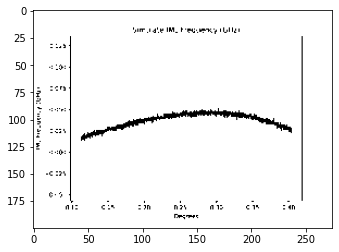

1 tf.Tensor([0.], shape=(1,), dtype=float32)


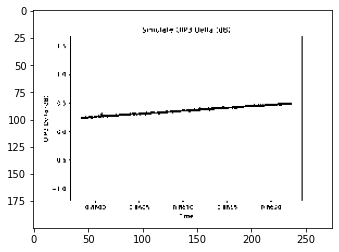

1 tf.Tensor([0.], shape=(1,), dtype=float32)


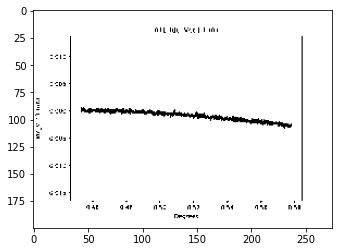

1 tf.Tensor([0.], shape=(1,), dtype=float32)


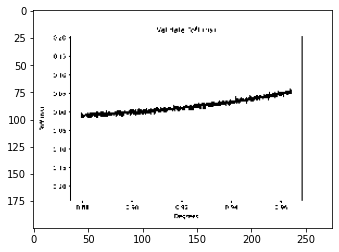

1 tf.Tensor([0.], shape=(1,), dtype=float32)


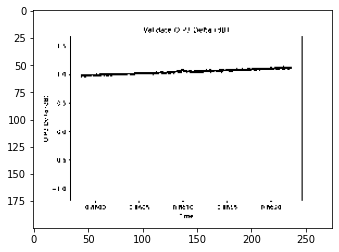

1 tf.Tensor([0.], shape=(1,), dtype=float32)


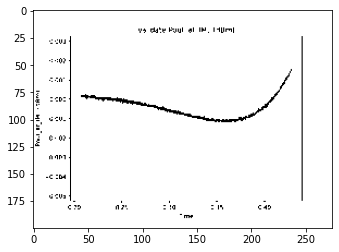

0 tf.Tensor([1.], shape=(1,), dtype=float32)


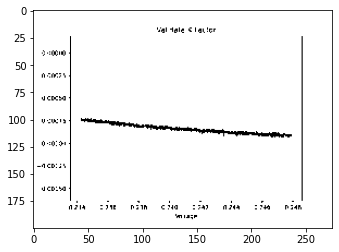

1 tf.Tensor([0.], shape=(1,), dtype=float32)


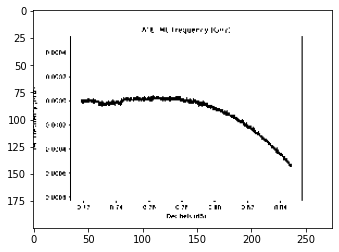

1 tf.Tensor([0.], shape=(1,), dtype=float32)


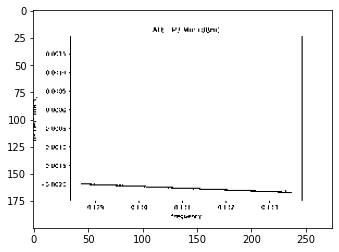

1 tf.Tensor([0.], shape=(1,), dtype=float32)


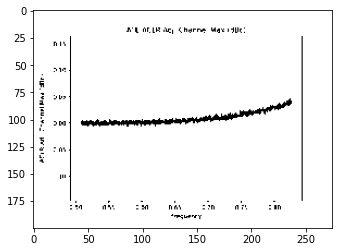

1 tf.Tensor([0.], shape=(1,), dtype=float32)


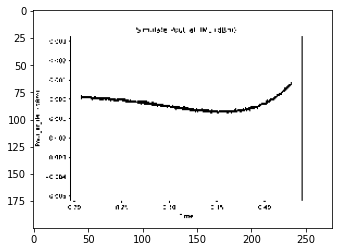

1 tf.Tensor([0.], shape=(1,), dtype=float32)


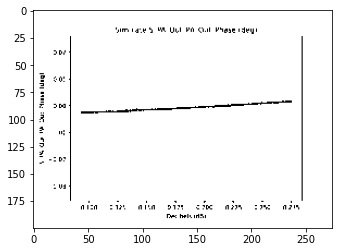

1 tf.Tensor([0.], shape=(1,), dtype=float32)


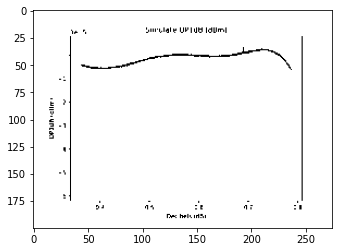

1 tf.Tensor([0.], shape=(1,), dtype=float32)


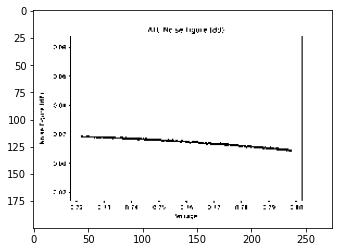

1 tf.Tensor([0.], shape=(1,), dtype=float32)


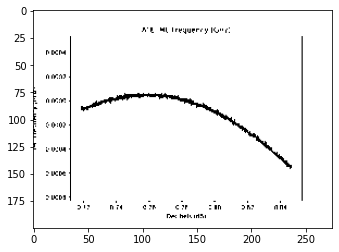

1 tf.Tensor([0.], shape=(1,), dtype=float32)


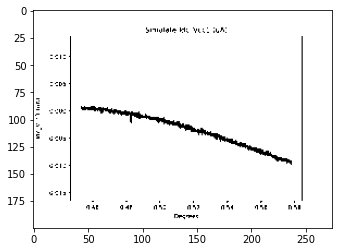

1 tf.Tensor([0.], shape=(1,), dtype=float32)


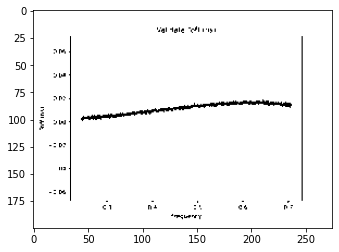

1 tf.Tensor([0.], shape=(1,), dtype=float32)


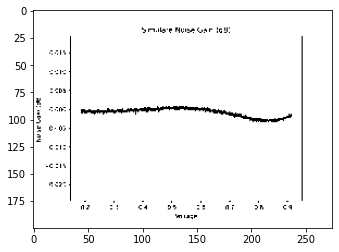

1 tf.Tensor([0.], shape=(1,), dtype=float32)


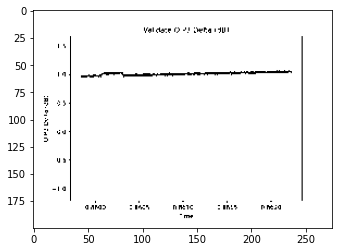

1 tf.Tensor([0.], shape=(1,), dtype=float32)


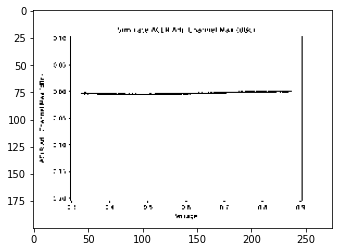

1 tf.Tensor([0.], shape=(1,), dtype=float32)


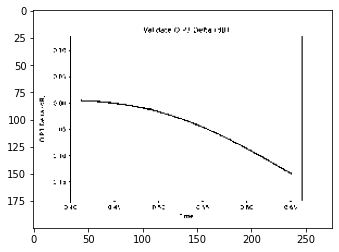

1 tf.Tensor([0.], shape=(1,), dtype=float32)


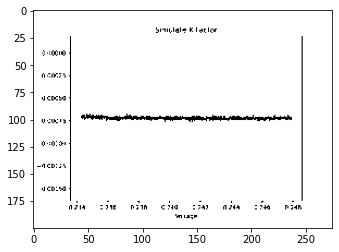

1 tf.Tensor([0.], shape=(1,), dtype=float32)


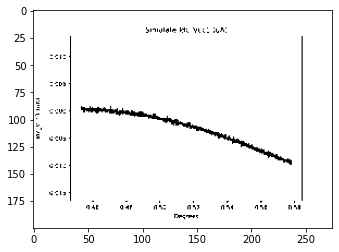

1 tf.Tensor([0.], shape=(1,), dtype=float32)


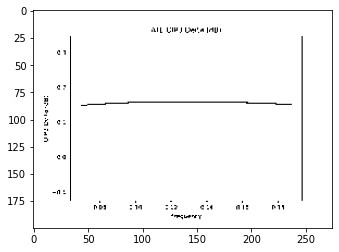

1 tf.Tensor([0.], shape=(1,), dtype=float32)


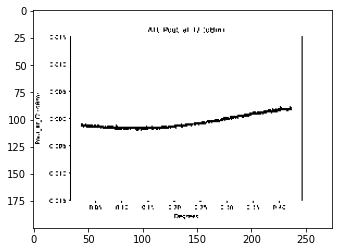

1 tf.Tensor([0.], shape=(1,), dtype=float32)


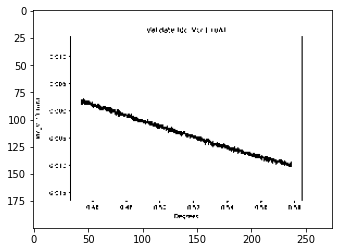

1 tf.Tensor([0.], shape=(1,), dtype=float32)


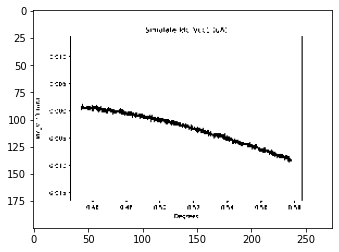

1 tf.Tensor([0.], shape=(1,), dtype=float32)


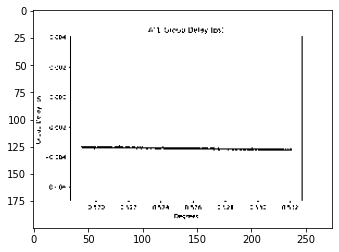

1 tf.Tensor([0.], shape=(1,), dtype=float32)


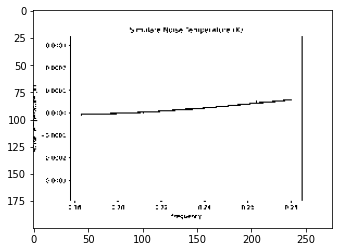

1 tf.Tensor([0.], shape=(1,), dtype=float32)


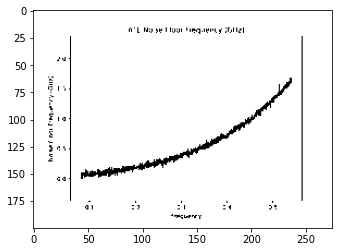

1 tf.Tensor([0.], shape=(1,), dtype=float32)


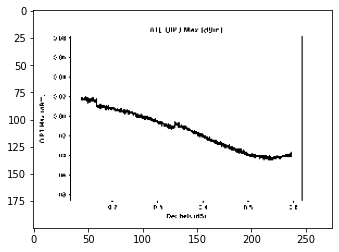

1 tf.Tensor([0.], shape=(1,), dtype=float32)


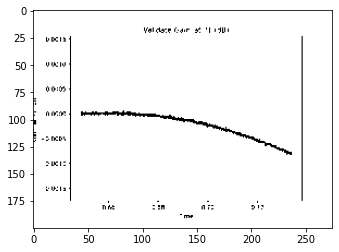

1 tf.Tensor([0.], shape=(1,), dtype=float32)


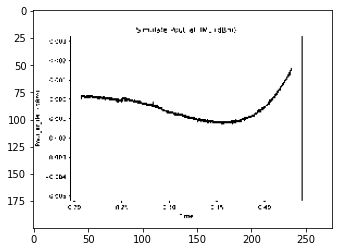

1 tf.Tensor([0.], shape=(1,), dtype=float32)


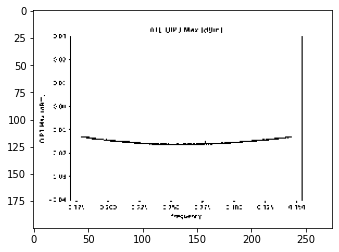

1 tf.Tensor([0.], shape=(1,), dtype=float32)


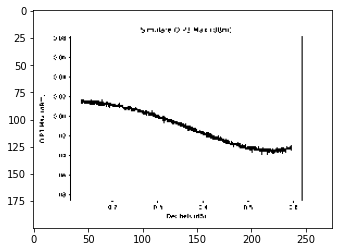

1 tf.Tensor([0.], shape=(1,), dtype=float32)


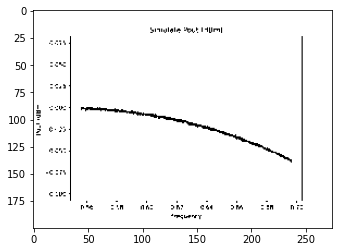

1 tf.Tensor([0.], shape=(1,), dtype=float32)


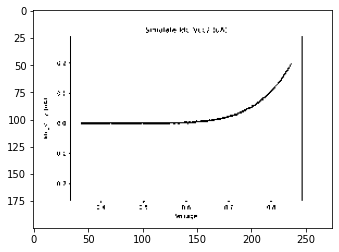

1 tf.Tensor([0.], shape=(1,), dtype=float32)


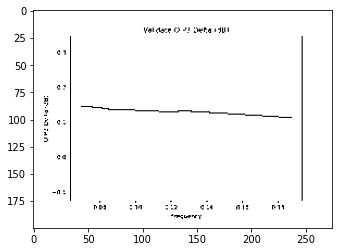

1 tf.Tensor([0.], shape=(1,), dtype=float32)


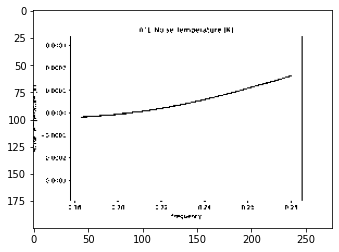

In [34]:
# display missclassified images
for i in range(len(X_test)):
  if y_test[i] != y_pred[i]:
    print(y_test[i], y_pred[i])
    X_test[i][0][0] = 0
    plt.imshow(X_test[i], 'gray')
    plt.show()